In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.set_style('ticks')

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# SVM vs Proto vs NN

In [5]:
manifolds_load = np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/manifolds.npy',
                   allow_pickle=True)

OSError: [Errno 5] Input/output error

In [4]:
P = 500
manifolds = []
for manifold in manifolds_load:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

NameError: name 'manifolds_load' is not defined

# Vary beta

In [239]:
m = 10
P = 50
D = 4
N = 5
n_avg = 10000

U = np.random.randn(N,D+1)
U,_ = np.linalg.qr(U)
x0 = U[:,-1] / 5
U = U[:,:-1]
betas = np.logspace(-5,2,10)
errs_proto = []
errs_ex = []
for beta in tqdm(betas):
    for _ in range(n_avg):
        sa = x0[:,None] + U@np.random.randn(D,P) / np.sqrt(D)
        sb = -x0[:,None] + U@np.random.randn(D,P) / np.sqrt(D)

        idxs = np.random.permutation(P)
        xa,ya = np.split(sa[:,idxs],(m,),axis=1)
        xb,yb = np.split(sb[:,idxs],(m,),axis=1)

        # Prototpye
        xabar = xa.mean(1,keepdims=True)
        xbbar = xb.mean(1,keepdims=True)
        h_proto = -((xabar-ya)**2).sum(0) + ((xbbar - ya)**2).sum(0)
        err_proto = (h_proto<0).mean()
        errs_proto.append(err_proto)

        # Exemplar
        da = (((xa[:,:,None] - ya[:,None]))**2).sum(0)
        db = (((xb[:,:,None] - ya[:,None]))**2).sum(0)
        sa = np.exp(-beta*da)
        sb = np.exp(-beta*db)
        h_ex = sa.sum(0) - sb.sum(0)
        err_ex = (h_ex<0).mean()
        errs_ex.append(err_ex)
errs_proto = np.stack(errs_proto).reshape(len(betas), n_avg)
errs_ex = np.stack(errs_ex).reshape(len(betas), n_avg)

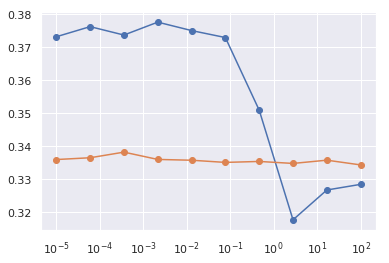

In [240]:
plt.plot(betas, errs_ex.mean(-1), 'o-')
plt.plot(betas, errs_proto.mean(-1), 'o-')
plt.xscale('log')

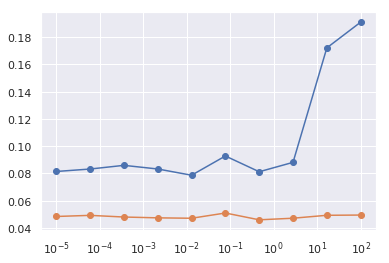

In [236]:
plt.plot(betas, errs_ex.mean(-1), 'o-')
plt.plot(betas, errs_proto.mean(-1), 'o-')
plt.xscale('log')

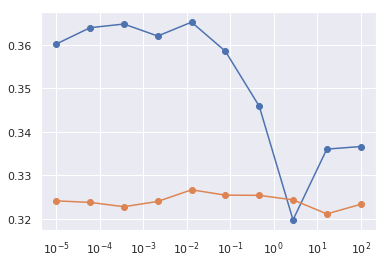

In [234]:
plt.plot(betas, errs_ex.mean(-1), 'o-')
plt.plot(betas, errs_proto.mean(-1), 'o-')
plt.xscale('log')

# Real manifolds

In [4]:
m = 5

from sklearn.neighbors import KNeighborsClassifier
NN = KNeighborsClassifier(n_neighbors=1)

def prototype_learning(m, xa, xb, ya):
    '''Performs a prototype learning experiment, with exponential weighting beta
    Args:
        - m: num training examples
        - xa: (N,m) training examples of object a
        - xb: (N,m) training example of object b
        - ya: (N,P-m) test examples of object a
    '''
    xabar = xa.mean(0,keepdims=True)
    xbbar = xb.mean(0,keepdims=True)
    h_proto = -((xabar-ya)**2).sum(-1) + ((xbbar - ya)**2).sum(-1)
    err_proto = (h_proto<0).mean()
    return err_proto


def exemplar_learning(m, xa, xb, ya, beta, NN=False):
    '''Performs an exemplar learning experiment, with exponential weighting beta
    Args:
        - m: num training examples
        - xa: (N,m) training examples of object a
        - xb: (N,m) training example of object b
        - ya: (N,P-m) test examples of object a
        - beta: Weighting of training examples. b->0 corresponds to equal weighting,
                b->\infty corresponds to 1-NN classifier.
        - NN: bool. Perform 1-NN classification, equivalent to beta->\infty
    '''
    da = (((xa[:,None] - ya[None]))**2).sum(-1)
    db = (((xb[:,None] - ya[None]))**2).sum(-1)
    sa = np.exp(-beta*da)
    sb = np.exp(-beta*db)
    h_ex = sa.sum(0) - sb.sum(0)
    err_ex = (h_ex<=0).mean()
    
    if NN:
        sa = -da.min(0)
        sb = -db.min(0)
        h_ex = sa - sb
        err_ex = (h_ex<=0).mean()
    return err_ex

In [5]:
# manifolds = np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/macaque/manifolds_IT.npy')
manifolds_load = np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/manifolds.npy',allow_pickle=True)

In [ ]:
P = 500
manifolds = []
for manifold in tqdm(manifolds_load):
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [ ]:
K = manifolds.shape[0]
P = manifolds.shape[1]
N = manifolds.shape[2]

In [ ]:
n_avg = 50000
betas = np.logspace(-4,-0.9,20)
y = np.concatenate([np.ones(m),-np.ones(m)])
proto_errs = []
ex_errs = []
NN_errs = []
for _ in tqdm(range(n_avg)):
    a,b = np.random.choice(K, 2, replace=False)
    Xa = manifolds[a]
    Xb = manifolds[b]

    perma = np.random.permutation(P)
    permb = np.random.permutation(P)
    xa,ya = np.split(Xa[perma],(m,))
    xb,yb = np.split(Xb[permb],(m,))

    proto_err = prototype_learning(m,xa,xb,ya)
    proto_errs.append(proto_err)
    for beta in betas:
        ex_err = exemplar_learning(m,xa,xb,ya,beta)
        ex_errs.append(ex_err)
    NN_err = exemplar_learning(m,xa,xb,ya,beta,NN=True)
    NN_errs.append(NN_err)
ex_errs = np.stack(ex_errs).reshape(n_avg, len(betas))

Text(0.5, 1.0, 'm=5')

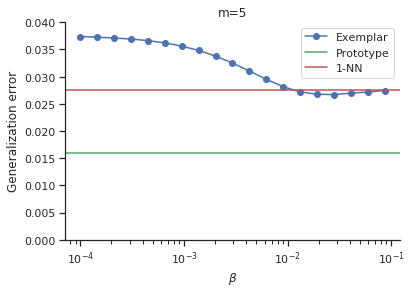

In [493]:
plt.plot(betas[:-1], ex_errs.mean(0)[:-1], 'o-', label='Exemplar')
plt.axhline(np.mean(proto_errs), c='C2', label='Prototype')
plt.axhline(np.mean(NN_errs), c='C3', label='1-NN')
plt.xscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel('Generalization error')

plt.ylim([0,0.04])
sns.despine()
plt.legend()
plt.title('m='+str(m))
# plt.savefig('images/exemplar_errors_vary_beta.pdf')

## Vary D and m

In [913]:
n_avg = 50000
betas = np.logspace(-4,-0.9,20)
y = np.concatenate([np.ones(m),-np.ones(m)])
proto_errs = []
ex_errs = []
NN_errs = []
ms = np.arange(1,10)
Ds = np.arange(1,100,10)

a,b = np.random.choice(K, 2, replace=False)
Xa = manifolds[a]
Xb = manifolds[b]
Ua,Sa,Va = np.linalg.svd(Xa-Xa.mean(0))
Ub,Sb,Vb = np.linalg.svd(Xb-Xb.mean(0))

for D in tqdm(Ds):
    for m in ms:
        Ya = Ua[:,:D]*Sa[:D]@Va[:D]
        Yb = Ub[:,:D]*Sb[:D]@Vb[:D]

        perma = np.random.permutation(P)
        permb = np.random.permutation(P)
        xa,ya = np.split(Ya[perma],(m,))
        xb,yb = np.split(Yb[permb],(m,))

        proto_err = prototype_learning(m,xa,xb,ya)
        proto_errs.append(proto_err)

        NN_err = exemplar_learning(m,xa,xb,ya,beta,NN=True)
        NN_errs.append(NN_err)
proto_errs = np.stack(proto_errs).reshape(len(Ds), len(ms))
NN_errs = np.stack(NN_errs).reshape(len(Ds), len(ms))

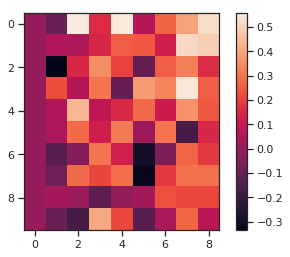

In [915]:
plt.imshow(proto_errs - NN_errs)
plt.colorbar()

# Nearest-neighbors theory

In [874]:
m = 5
ms = np.arange(1,100,5)
N = 500
D = 400
P = 1100
U = np.random.randn(N,D)
U,_ = np.linalg.qr(U)

navg = 10
has = []
hs = []
for m in tqdm(ms):
    for _ in range(navg):
        x0 = np.random.randn(N) / np.sqrt(N)

        sa = np.random.randn(D,m) / np.sqrt(D)
        xa = x0[:,None] + U@sa

        ssa = np.random.randn(D,P) / np.sqrt(D)
        ya = x0[:,None] + U@ssa

        sb = np.random.randn(D,m) / np.sqrt(D)
        xb = -x0[:,None] + U@sb

        da = ((xa[:,None] - ya[:,:,None])**2).sum(0) / 2
        db = ((xb[:,None] - ya[:,:,None])**2).sum(0) / 2

        ha = da.min(-1)
        has.append(ha)
        
        hb = db.min(-1)
        h = -ha + hb
        hs.append(h)
has = np.stack(has).reshape(len(ms),navg,-1)
hs = np.stack(hs).reshape(len(ms),navg,-1)

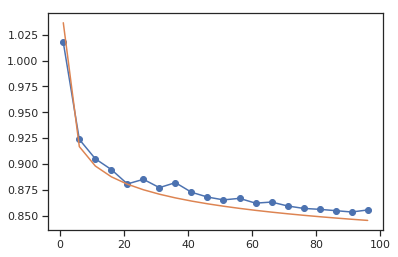

In [875]:
plt.plot(ms,has.mean(-1).mean(-1), 'o-')
sigma = np.sqrt(2/N)
plt.plot(ms,1 - (np.sqrt(2*np.log(ms)) - np.euler_gamma)*sigma)

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


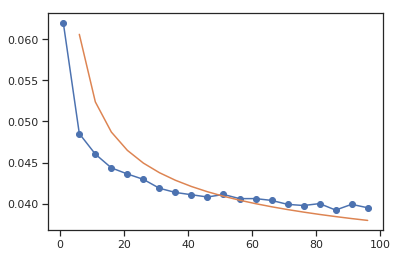

In [884]:
plt.plot(ms,has.std(-1).mean(-1), 'o-')
plt.plot(ms,sigma*np.sqrt(2)/np.sqrt(2*np.log(ms))*np.pi/np.sqrt(6))

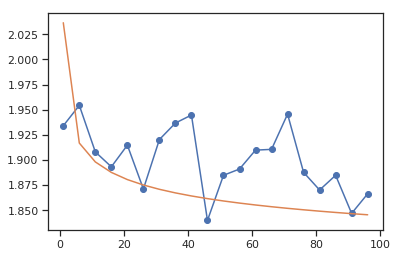

In [885]:
plt.plot(ms,hs.mean(-1).mean(-1), 'o-')
plt.plot(ms,2 - (np.sqrt(2*np.log(ms)) - np.euler_gamma)*sigma)

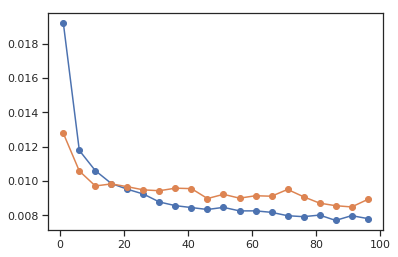

In [892]:
plt.plot(ms,5*has.var(-1).mean(-1), 'o-')
plt.plot(ms,hs.var(-1).mean(-1), 'o-')
# plt.plot(ms,(sigma*np.sqrt(2)/np.sqrt(2*np.log(ms))*np.pi/np.sqrt(6))**2)

In [524]:
h = -da.min(-1) + db.min(-1)

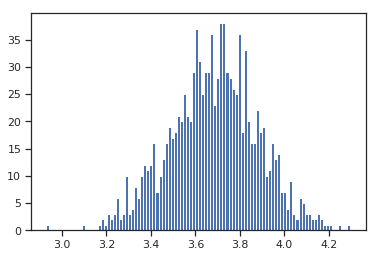

In [529]:
plt.hist(h, bins=100);

In [785]:
Ameans = []
Astds = []
ms = np.logspace(0,3,20, dtype='int')
sigma = 5
for m in tqdm(ms):
    X = np.random.randn(m,1000) * 5
    A = X.max(0)
    Ameans.append(A.mean())
    Astds.append(A.std())

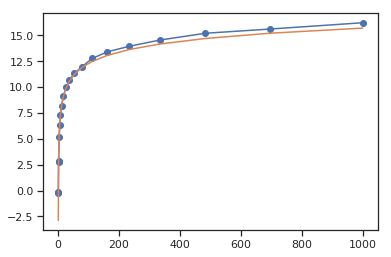

In [787]:
plt.plot(ms,Ameans,'o-')
plt.plot(ms,sigma*(np.sqrt(2*np.log(ms)) - np.euler_gamma))

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


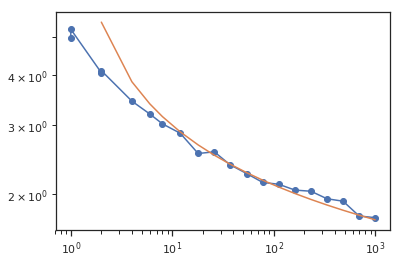

In [788]:
plt.plot(ms,Astds, 'o-')
plt.plot(ms,sigma/np.sqrt(2*np.log(ms))*np.pi/np.sqrt(6))
plt.yscale('log')
plt.xscale('log')

(array([  3.,  35., 110., 202., 284., 229., 165.,  61.,   9.,   2.]),
 array([0.80182787, 0.84403918, 0.88625049, 0.92846179, 0.9706731 ,
        1.01288441, 1.05509571, 1.09730702, 1.13951833, 1.18172963,
        1.22394094]),
 <a list of 10 Patch objects>)

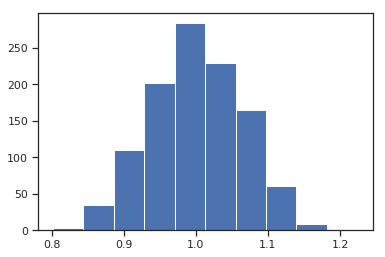

In [791]:
x = np.random.randn(N,P) / np.sqrt(N)
plt.hist((x**2).sum(0))

(array([  7.,  24., 101., 226., 278., 262., 144.,  43.,  12.,   3.]),
 array([-0.14558271, -0.11480508, -0.08402745, -0.05324983, -0.0224722 ,
         0.00830543,  0.03908306,  0.06986069,  0.10063832,  0.13141595,
         0.16219358]),
 <a list of 10 Patch objects>)

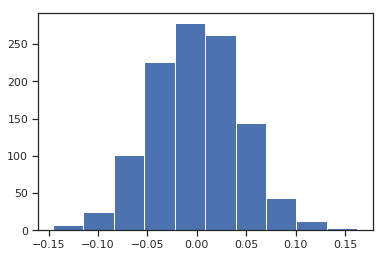

In [800]:
x = np.random.randn(N,P) / np.sqrt(N)
y = np.random.randn(N,P) / np.sqrt(N)
plt.hist((x*y).sum(0))

## Testing theory

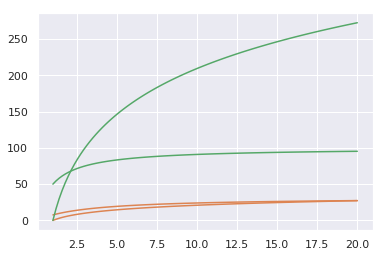

In [15]:
ms = np.linspace(1,20,100)
cs = 0.1
D = 10
plt.plot(ms, np.log(ms)/(1/D + cs/D), c='C1')
plt.plot(ms, 1/(1/D/ms + cs/np.sqrt(D)), c='C1')

D = 100
plt.plot(ms, np.log(ms)/(1/D + cs/D), c='C2')
plt.plot(ms, 1/(1/D/ms + cs/np.sqrt(D)), c='C2')

In [185]:
U.shape

(5, 5)

In [193]:
U.shape

(5, 5)

In [195]:
2*(D+1)

6

In [201]:
m = 5
N = 100
P = 100
n_avg = 50

err_protos = []
err_NNs = []
ms = np.arange(2,100,8)
Ns = np.arange(5,40,5)
for m in tqdm(ms):
    for N in Ns:
        D = N//3
        for _ in range(n_avg):
#             x0 = np.random.randn(N)
#             x0 /= np.linalg.norm(x0)
#             x0 /= 2
            
            U = np.random.randn(N,2*(D+1))
            U,_ = np.linalg.qr(U)
            Ua,Ub,x0a,x0b = np.split(U,(D,2*D,2*D+1),axis=1)

            sa = np.random.randn(D,m) / np.sqrt(D)
#             sa /= np.linalg.norm(sa,axis=0)
            sb = np.random.randn(D,m) / np.sqrt(D)
#             sb /= np.linalg.norm(sa,axis=0)
            ss = np.random.randn(D,P) / np.sqrt(D)
#             ss /= np.linalg.norm(ss,axis=0)

            xa = (x0a/5 + Ua@sa).T
            xb = (x0b/5 + Ub@sb).T
            xia = (x0a/5 + Ua@ss).T

            da = ((xa[:,None] - xia[None])**2).sum(-1)
            db = ((xb[:,None] - xia[None])**2).sum(-1)
            h = -da.min(0) + db.min(0)
            errNN = (h<0).mean()

            daproto = ((xa.mean(0) - xia[None])**2).sum(-1)
            dbproto = ((xb.mean(0) - xia[None])**2).sum(-1)
            hproto = -daproto + dbproto
            errproto = (hproto<0).mean()

            err_protos.append(errproto)
            err_NNs.append(errNN)
err_protos = np.stack(err_protos).reshape(len(ms),len(Ns),n_avg).mean(-1).T
err_NNs = np.stack(err_NNs).reshape(len(ms),len(Ns),n_avg).mean(-1).T

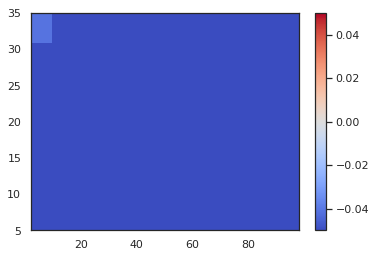

In [202]:
plt.imshow(err_NNs - err_protos,
           cmap='coolwarm', origin='lower', extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
          aspect='auto', vmin=-0.05,vmax=0.05)
plt.colorbar()
plt.ylim(np.min(Ns),np.max(Ns))
xx = np.linspace(np.min(ms),np.max(ms),100)
plt.plot(xx,np.log(xx), c='black')

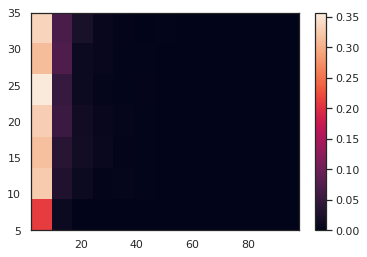

In [203]:
plt.imshow(err_NNs, origin='lower', extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
          aspect='auto')
plt.colorbar()

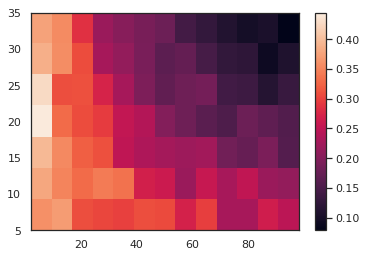

In [204]:
plt.imshow(err_protos, origin='lower', extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
          aspect='auto')
plt.colorbar()

In [125]:
sns.set_style('white')

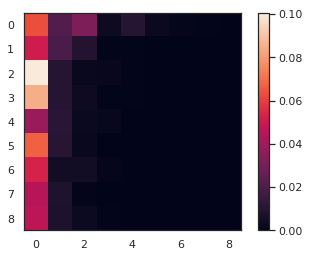

In [126]:
plt.imshow(err_NNs.mean(-1))
plt.colorbar()

In [73]:
(hproto<0).mean()

0.0018181818181818182

(array([  2.,   5.,  31., 113., 259., 334., 225.,  97.,  30.,   4.]),
 array([-0.02604609, -0.02113887, -0.01623166, -0.01132444, -0.00641722,
        -0.00151001,  0.00339721,  0.00830443,  0.01321165,  0.01811886,
         0.02302608]),
 <a list of 10 Patch objects>)

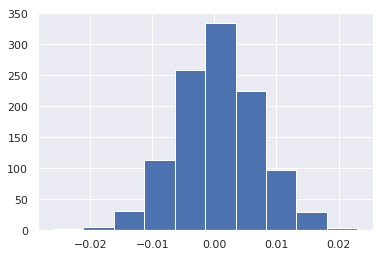

In [59]:
plt.hist(h)

In [28]:
xia.shape

(1100, 10)

In [30]:
xa.shape

(5, 10)

In [36]:
%%timeit
(np.einsum('ik,jk->ijk',xa,-xia)**2).sum(-1)

90 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
%%timeit
((xia[None] - xa[:,None])**2).sum(-1)

98.7 µs ± 514 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# How do CS and SS vary with D

In [205]:
def geometry(centers,Rs,Us,m):
    K = len(centers)
    P = Rs.shape[1]
    dists = np.sqrt(((centers[:,None] - centers[None])**2).sum(-1))
    dist_norm = dists / np.sqrt((Rs**2).sum(-1)[:,None] / P)

    Ds = np.sum(Rs**2,axis=-1)**2 / np.sum(Rs**4, axis=-1)

    # Center-subspace
    csa = []
    csb = []
    for a in range(K):
        for b in range(K):
            if a!=b:
                dx0 = centers[a] - centers[b]
                dx0hat = dx0 / np.linalg.norm(dx0)
                costheta_a = Us[a]@dx0hat
                csa.append((costheta_a**2 * Rs[a]**2).sum() / (Rs[a]**2).sum())
                costheta_b = Us[b]@dx0hat
                csb.append((costheta_b**2 * Rs[b]**2).sum() / (Rs[a]**2).sum())
            else:
                csa.append(np.nan)
                csb.append(np.nan)
    csa = np.stack(csa).reshape(K,K)
    csb = np.stack(csb).reshape(K,K)

    # Subspace-subspace
    ss = []
    for a in range(K):
        for b in range(K):
            if a!=b:
                cosphi = Us[a]@Us[b].T
                ss_overlap = (cosphi**2*Rs[a][:,None]**2*Rs[b]**2).sum() / (Rs[a]**2).sum()**2
                ss.append(ss_overlap)
            else:
                ss.append(np.nan)
    ss = np.stack(ss).reshape(K,K)

    css = (csa + csb/m) * dist_norm**2

    bias = (Rs**2).sum(-1) / (Rs**2).sum(-1)[:,None] - 1
    SNR = 1/2*(dist_norm**2 + bias/m)/ np.sqrt(1/Ds[:,None]/m + css + ss/m)
    
    return dist_norm, Ds, csa, csb, ss, SNR

In [4]:
manifolds_load = np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/manifolds.npy',
                   allow_pickle=True)

In [5]:
P = 500
manifolds = []
for manifold in manifolds_load:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [212]:
manifolds = manifolds[:100]

In [217]:
manifolds = manifolds[:20]

In [265]:
Rs = []
centers = []
Us = []
for manifold in tqdm(manifolds):
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    centers.append(manifold.mean(0))
    Rs.append(R)
    Us.append(V)
Rs = np.stack(Rs)
centers = np.stack(centers)
Us = np.stack(Us)

In [268]:
Rs = []
Us = []
Vs = []
centers = []
for manifold in tqdm(manifolds):
    centers.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs.append(R)
    Us.append(V)
    Vs.append(U)
centers = np.stack(centers)
Rs = np.stack(Rs)
Us = np.stack(Us)
Vs = np.stack(Vs)

In [392]:
m = 5
ks = np.arange(10,500,10)

dist_norms = []
Ds_all = []
csa_all = []
csb_all = []
ss_all = []
SNR_all = []
for k in tqdm(ks):
    Rs_k = []
    Us_k = []
    centers_k = []
    for U,R,V,center in zip(Us,Rs,Vs,centers):
        centers_k.append((V[:,:k]*R[:k]@U[:k] + center).mean(0))
        Rs_k.append(R[:k])
        Us_k.append(U[:k])
    Rs_k = np.stack(Rs_k)
    Us_k = np.stack(Us_k)
    centers_k = np.stack(centers_k)
    
    dist_norm, Ds, csa, csb, ss, SNR = geometry(centers_k,Rs_k,Us_k,m)
    dist_norms.append(dist_norm)
    Ds_all.append(Ds)
    csa_all.append(csa)
    csb_all.append(csb)
    ss_all.append(ss)
    SNR_all.append(SNR)

In [393]:
SNR_all = np.stack(SNR_all).reshape(len(ks),-1)
Ds_all = np.stack(Ds_all)
csa_all = np.stack(csa_all).reshape(len(ks),-1)
ss_all = np.stack(ss_all).reshape(len(ks),-1)

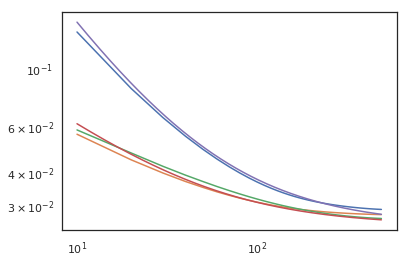

In [396]:
plt.plot(ks,1/Ds_all.mean(-1))
plt.plot(ks,np.nanmean(csa_all,-1))
plt.plot(ks,3.8*np.nanmean(ss_all,-1))
plt.yscale('log')
plt.xscale('log')
xx = np.linspace(np.min(ks),np.max(ks),1000)
plt.plot(xx,0.025*np.sqrt(1+50/xx))
plt.plot(xx,0.025*(1+50/xx))

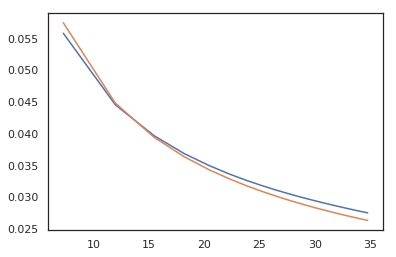

In [404]:
plt.plot(Ds_all.mean(-1),np.nanmean(csa_all,-1))
plt.plot(Ds_all.mean(-1), 0.155/np.sqrt(Ds_all.mean(-1)))

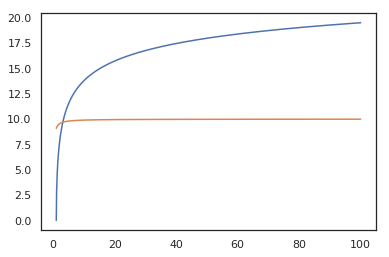

In [441]:
ms = np.linspace(1,100,1000)
cs = 0.1
D = 100
a = np.sqrt(np.log(ms))/(1/D + cs)
b = 1/(1/D/ms + cs)
plt.plot(ms,a)
plt.plot(ms,b)

In [451]:
Ds = np.linspace(100,1000,100)
m0s = []
for D in Ds:
    a = np.sqrt(np.log(ms))/(1/D + cs/np.sqrt(D))
    b = 1/(1/D/ms + cs/np.sqrt(D))
    m0s.append(ms[np.argmin((a-b)**2)])

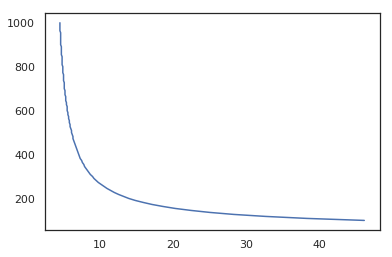

In [452]:
plt.plot(m0s,Ds)
# plt.plot(m0s,0.001*np.log(m0s))

In [363]:
np.nanmean(csa_all,-1)

array([0.05582305, 0.04453297, 0.03965799, 0.03680472, 0.03493762,
       0.03357906, 0.03257399, 0.03179016, 0.03116685])

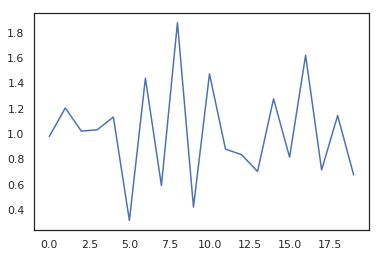

In [364]:
plt.plot(np.nanmean(SNR,-1))

In [ ]:
centers.append((U[:,:k]*R[:k]@V[:k]).mean(0))

In [229]:
k = 5
(U[:,:k]*R[:k]@V[:k]).mean(0)

array([ 1.5847386e-08, -8.4191560e-09, -7.0668755e-09, ...,
       -1.8872321e-08, -2.0876527e-08,  1.5214086e-08], dtype=float32)

In [225]:
manifold.shape

(500, 2048)

In [226]:
Us.shape

(20, 500, 2048)

In [ ]:
Ua,Sa,Va = np.linalg.svd(manifold - manifold.mean(0))

In [219]:
dist_norm, Ds, csa, csb, ss, SNR = geometry(centers,Rs,Us,m)

In [640]:
Xatrain.shape

(38, 2048)

In [644]:
Xatest.shape

(462, 2048)

In [645]:
da = ((Xatrain.mean(0) - Xatest)**2).sum(-1)

In [646]:
da.shape

(462,)

In [704]:
Sa.shape

(500,)

In [1048]:
m = 5

means = []
stds = []
means_proto = []
stds_proto = []
errs_proto = []
errs_NN = []
ms = np.arange(2,100,4)
ks = np.arange(1,100,4)
navg = 500
for _ in tqdm(range(navg)):
    a,b = np.random.choice(100,2,replace=False)
    Xa = manifolds[a]
    Xb = manifolds[b]
    
    Ua,Sa,Va = np.linalg.svd(Xa - Xa.mean(0), full_matrices=False)
    Ub,Sb,Vb = np.linalg.svd(Xb - Xb.mean(0), full_matrices=False)
    for k in ks:
        Xak = Ua[:,:k]*Sa[:k]@Va[:k] * (Sa**2).sum()/(Sa[:k]**2).sum() + Xa.mean(0)
        Xbk = Ub[:,:k]*Sb[:k]@Vb[:k] * (Sb**2).sum()/(Sb[:k]**2).sum() + Xb.mean(0)
        for m in ms:
            perma = np.random.permutation(P)
            permb = np.random.permutation(P)
            Xatrain,Xatest = np.split(Xak[perma],(m,))
            Xbtrain,_ = np.split(Xbk[permb],(m,))

            da = ((Xatrain[:,None] - Xatest[None])**2).sum(-1).min(0)
            db = ((Xbtrain[:,None] - Xatest[None])**2).sum(-1).min(0)
            h = -da + db
            errs_NN.append((h<0).mean())

            means.append(h.mean())
            stds.append(h.std())
            
            da = ((Xatrain.mean(0) - Xatest)**2).sum(-1)
            db = ((Xbtrain.mean(0) - Xatest)**2).sum(-1)
            hproto = -da + db
            errs_proto.append((hproto<0).mean())
            means_proto.append(hproto.mean())
            stds_proto.append(hproto.std())
means = np.stack(means).reshape(navg,len(ks),len(ms)).mean(0)
stds = np.stack(stds).reshape(navg,len(ks),len(ms)).mean(0)
means_proto = np.stack(means_proto).reshape(navg,len(ks),len(ms)).mean(0)
stds_proto = np.stack(stds_proto).reshape(navg,len(ks),len(ms)).mean(0)
errs_NN = np.stack(errs_NN).reshape(navg,len(ks),len(ms)).mean(0)
errs_proto = np.stack(errs_proto).reshape(navg,len(ks),len(ms)).mean(0)

In [1068]:
os.mkdir('data/proto_vs_NN_experiments')

In [1071]:
np.save('data/proto_vs_NN_experiments/NNmeans.npy', means)
np.save('data/proto_vs_NN_experiments/NNstds.npy', stds)
np.save('data/proto_vs_NN_experiments/proto_means.npy', means_proto)
np.save('data/proto_vs_NN_experiments/proto_stds.npy', stds_proto)
np.save('data/proto_vs_NN_experiments/NNerrs.npy', errs_NN)
np.save('data/proto_vs_NN_experiments/proto_errs.npy', errs_proto)

In [1049]:
SNR = means/stds

In [1050]:
SNR_proto = means_proto/stds_proto

In [1002]:
sns.set_style('white')

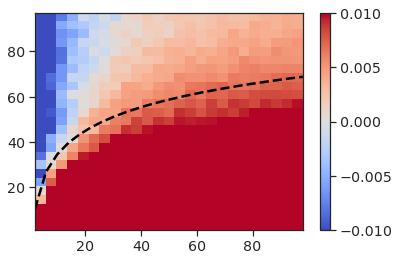

In [1051]:
plt.imshow(errs_proto - errs_NN ,
           origin='lower', extent=(np.min(ms),np.max(ms),np.min(ks),np.max(ks)),
           cmap='coolwarm', aspect='auto', vmin=-0.01,vmax=0.01)
plt.plot(ms, 15*np.log(ms), c='black', linestyle='dashed')
plt.colorbar()

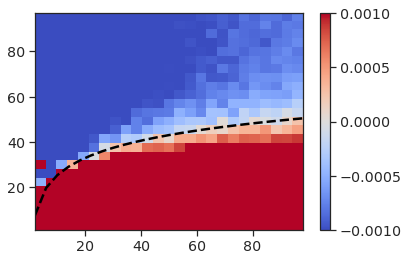

In [1058]:
plt.imshow(H(SNR_proto) - H(SNR),
           origin='lower', extent=(np.min(ms),np.max(ms),np.min(ks),np.max(ks)),
          vmin=-0.001,vmax=0.001, cmap='coolwarm', aspect='auto')
plt.plot(ms, 11*np.log(ms), c='black', linestyle='dashed')
plt.colorbar()

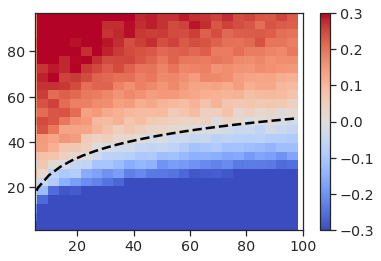

In [1067]:
plt.imshow(SNR_proto - SNR,
           origin='lower', extent=(np.min(ms),np.max(ms),np.min(ks),np.max(ks)),
          vmin=-0.3,vmax=0.3, cmap='coolwarm', aspect='auto')
plt.plot(ms, 11*np.log(ms), c='black', linestyle='dashed')
plt.colorbar()
plt.xlim([5,100])
plt.savefig('images/SNR_proto_NN_low_high_D.pdf')

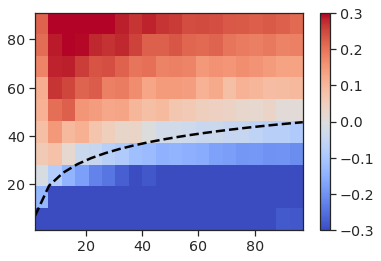

In [1008]:
plt.imshow(SNR_proto - SNR,
           origin='lower', extent=(np.min(ms),np.max(ms),np.min(ks),np.max(ks)),
          vmin=-0.3,vmax=0.3, cmap='coolwarm', aspect='auto')
plt.plot(ms, 10*np.log(ms), c='black', linestyle='dashed')
plt.colorbar()

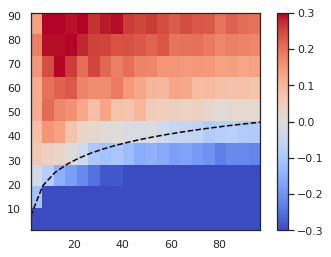

In [930]:
plt.imshow(SNR_proto - SNR,
           origin='lower', extent=(np.min(ms),np.max(ms),np.min(ks),np.max(ks)),
          vmin=-0.3,vmax=0.3, cmap='coolwarm')
plt.plot(ms, 10*np.log(ms), c='black', linestyle='dashed')
plt.colorbar()

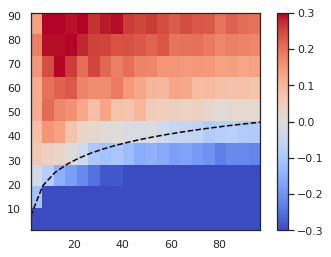

In [929]:
plt.imshow(SNR_proto - SNR,
           origin='lower', extent=(np.min(ms),np.max(ms),np.min(ks),np.max(ks)),
          vmin=-0.3,vmax=0.3, cmap='coolwarm')
plt.plot(ms, 10*np.log(ms), c='black', linestyle='dashed')
plt.colorbar()

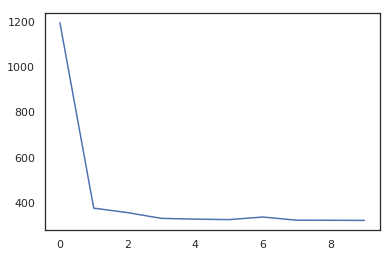

In [909]:
plt.plot(means[:,0])

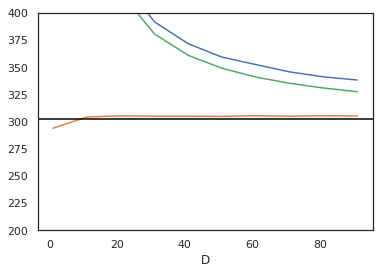

In [924]:
# Does this curve look like 1/sqrt(D) for NN?
plt.plot(ks,means.mean(-1))
plt.plot(ks,means_proto.mean(-1))
plt.plot(ks, 300 + 2500/ks)
plt.xlabel('D')
plt.ylim([200,400])
plt.axhline(((centers[None] - centers[:,None])**2).sum(-1).mean(), c='black')
# plt.xscale('log')
# plt.yscale('log')

In [922]:
((centers[None] - centers[:,None])**2).sum(-1).mean()

302.58987

In [921]:
centers = manifolds.mean(1)

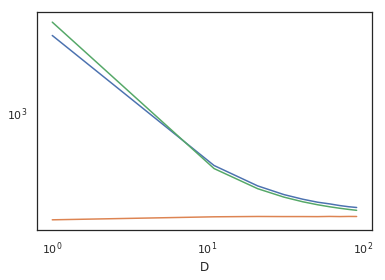

In [900]:
# Does this curve look like 1/sqrt(D) for NN?
plt.plot(ks,means.mean(-1))
plt.plot(ks,means_proto.mean(-1))
plt.plot(ks, 300 + 2500/ks)
plt.xlabel('D')
plt.xscale('log')
plt.yscale('log')

Text(0.5, 0, 'D')

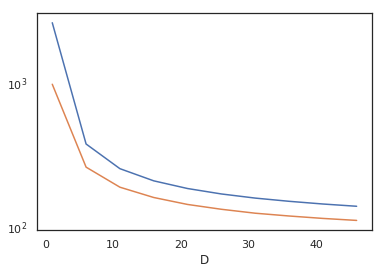

In [766]:
plt.plot(ks,stds.mean(-1))
plt.plot(ks,stds_proto.mean(-1))
plt.yscale('log')
plt.xlabel('D')

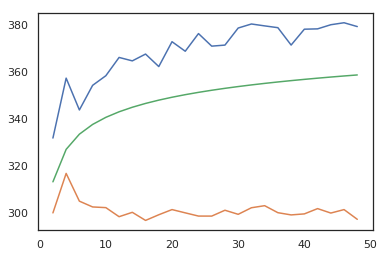

In [842]:
i =  7
plt.plot(ms,means[i])
plt.plot(ms,means_proto[i])
plt.plot(ms,280 + 40*np.sqrt(np.log(ms)))

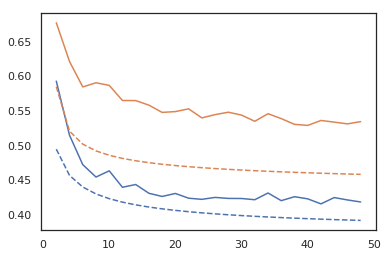

In [826]:
i = -3
plt.plot(ms,stds_proto[i] / (Sa**2).mean())
plt.plot(ms,stds[i] / (Sa**2).mean())
plt.plot(ms,2/np.sqrt(30) + 1/np.sqrt(30)/np.sqrt(ms), c='C0', linestyle='dashed')
plt.plot(ms,2/np.sqrt(30) + 1/np.sqrt(30)/np.sqrt(np.log(ms)), c='C1', linestyle='dashed')

In [ ]:
means_proto = np.stack(means_proto).reshape(navg,len(ms)).mean(0)
stds_proto = np.stack(stds_proto).reshape(navg,len(ms)).mean(0)

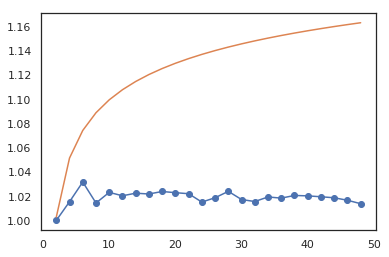

In [616]:
plt.plot(ms,means / means[0], 'o-')
plt.plot(ms,  0.885 + np.sqrt(np.log(ms)/50))

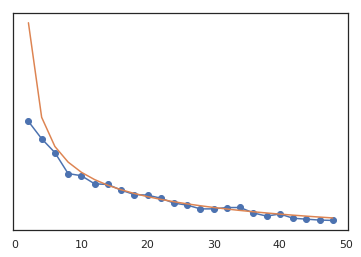

In [638]:
plt.plot(ms,stds, 'o-')
plt.plot(ms, 86+ 30/np.sqrt(np.log(ms)))
# plt.plot(ms,  90/np.sqrt(np.log(ms)))
plt.yscale('log')
plt.xscale('log')

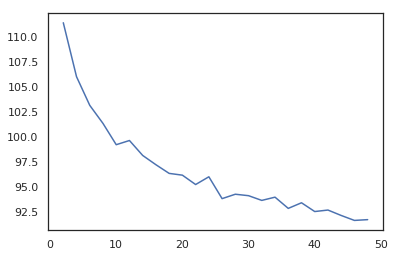

In [586]:
plt.plot(ms,dastds)
# # plt.plot(ms,  40/np.sqrt(np.log(ms)))
# plt.yscale('log')
# plt.xscale('log')

In [459]:
Xa[perma]

array([[0.38111216, 0.52027965, 0.49140626, ..., 0.03151985, 0.65531063,
        0.18960212],
       [0.79832244, 0.7565186 , 0.58024013, ..., 0.5508813 , 0.3474823 ,
        0.17765118],
       [0.6695899 , 0.98721033, 0.57111484, ..., 1.0206422 , 0.23463504,
        0.03145358],
       ...,
       [0.17770825, 1.0032907 , 0.78814465, ..., 0.24038105, 0.2358984 ,
        0.04930488],
       [0.63478   , 0.21225798, 0.24332544, ..., 0.68492836, 0.56167865,
        0.27396348],
       [0.8547704 , 0.1623756 , 0.01903364, ..., 0.33684137, 0.11249855,
        0.3448363 ]], dtype=float32)

# Angle between examples

In [221]:
a = 1

Ua,Sa,Va = np.linalg.svd(manifolds[a] - manifolds[a].mean(0))
Ub,Sb,Vb = np.linalg.svd(manifolds[b] - manifolds[b].mean(0))

In [217]:
Xa = manifolds[a] - manifolds.mean((0,1))
Xb = manifolds[b] - manifolds.mean((0,1))

In [218]:
mu = manifolds.mean((0,1))

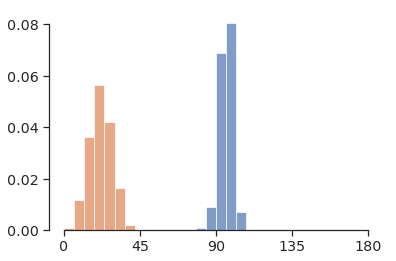

In [222]:
Xa = manifolds[a] - mu
Xa /= np.linalg.norm(Xa,axis=-1,keepdims=True)
Xb = manifolds[b] - mu
Xb /= np.linalg.norm(Xb,axis=-1,keepdims=True)
thetas = np.arccos((Xa@Xb.T).ravel())*180/np.pi
plt.hist(thetas, range=(0,180), bins=30, alpha=0.7,density=True);

k = 2
Xa = Ua[:,:k]*Sa[:k]@Va[:k] - mu
Xb = Ub[:,:k]*Sb[:k]@Vb[:k] - mu
Xa /= np.linalg.norm(Xa,axis=-1,keepdims=True)
Xb /= np.linalg.norm(Xb,axis=-1,keepdims=True)
thetas = np.arccos((Xa@Xb.T).ravel())*180/np.pi
plt.hist(thetas, range=(0,180), bins=30, alpha=0.7,density=True);
plt.xticks([0,45,90,135,180])
sns.despine(trim=True)


/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in arccos


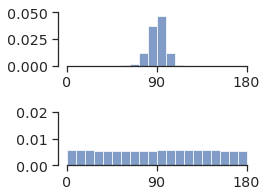

In [245]:
P = 500
mask = np.eye(P,dtype='bool')

plt.figure(figsize=(4,3))

k = 500
X = Ua[:,:k]*Sa[:k]@Va[:k]
X /= np.linalg.norm(X,axis=-1,keepdims=True)
thetas = np.arccos((X@X.T)[~mask])*180/np.pi
plt.subplot(211)
plt.hist(thetas, range=(0,180), bins=20, alpha=0.7,density=True,color='C0');
plt.xticks([0,90,180])
plt.ylim([0,0.05])

k = 2
X = Ua[:,:k]*Sa[:k]@Va[:k]
X /= np.linalg.norm(X,axis=-1,keepdims=True)
plt.subplot(212)
thetas = np.arccos((X@X.T)[~mask])*180/np.pi
plt.hist(thetas, range=(0,180), bins=20, alpha=0.7,density=True,color='C0');
plt.xticks([0,90,180])
plt.ylim([0,0.02])

sns.despine(trim=True)
plt.tight_layout()
plt.savefig('images/training_examples_angles_low_high_D.pdf')

In [247]:
Ds = np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/Ds.npy')

(0.30868987546161697,
 1.8641163066900437,
 0.4735748534088825,
 2.519388440533038)

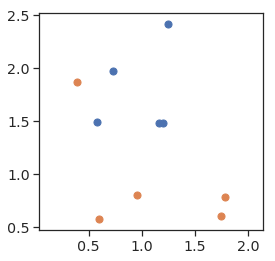

In [93]:
plt.figure(figsize=(4,4))
mua = [1,2]
xa = mua + np.random.randn(5,2)/2
plt.scatter(xa[:,0],xa[:,1],s=50)

mub = [2,1]
xb = mub + np.random.randn(5,2)/2
plt.scatter(xb[:,0],xb[:,1],s=50)
plt.axis('equal')

In [95]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

In [190]:
a,b = np.random.choice(1000,2,replace=False)

xa = manifolds[a][:5]
xb = manifolds[b][:5]

In [191]:
y = np.concatenate([np.ones(5),-np.ones(5)])

knn.fit(np.vstack([xa,xb]),y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [204]:
P = np.vstack([xa[1],xb[0]]).T
P,_ = np.linalg.qr(P)
xPa = xa@P
xPb = xb@P
xP = np.vstack([xPa,xPb])

xx = np.stack(np.meshgrid(np.linspace(xP[:,0].min(),xP[:,0].max(),100),
                          np.linspace(xP[:,1].min(),xP[:,1].max(),100)))
xx = xx.reshape(2,-1)
Pxx = P@xx

wproto = xa.mean(0) - xb.mean(0)
bproto = wproto@(xa.mean(0) + xb.mean(0))/2

wP = wproto@P

In [206]:
xP.shape

(10, 2)

In [210]:
bproto = (xP@wP).mean()/2

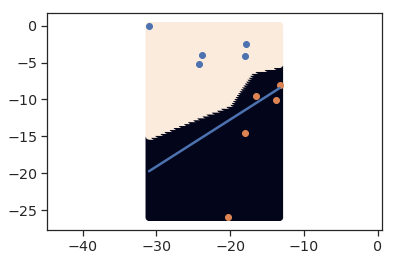

In [214]:

plt.scatter(xx[0],xx[1],c=knn.predict(Pxx.T))
plt.scatter(xPa[:,0],xPa[:,1])
plt.scatter(xPb[:,0],xPb[:,1])

tt = np.linspace(xP[:,0].min(),xP[:,0].max())
plt.plot(tt,-wP[0]*tt/wP[1] )
plt.axis('equal');

In [140]:
Pxx.shape

(2048, 100)